<a href="https://colab.research.google.com/github/Rosalee830/Rosalee830/blob/main/YouTube_8m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np # linear algebra
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
!pip install chart-studio
import chart_studio.plotly as py
import os
print(os.listdir("/YouTube-8m"))
# video level feature file
print(os.listdir("/YouTube-8m/video"))
# frame level features file
print(os.listdir("/YouTube-8m/frame"))


['frame', 'video', '.ipynb_checkpoints']
['train01.tfrecord', 'train00.tfrecord']
['train01.tfrecord', 'train00.tfrecord']


In [ ]:
# keras imports
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
import operator
import time 
import gc
import os

Creating training and validate dataset by combining video_rgb, video_audio, frame_rgb, frame_audio and labels

In [ ]:
def create_train_dev_dataset(video_rgb, video_audio, frame_rgb, frame_audio, labels):
    """
    Method to created training and validation data
    """
    shuffle_indices = np.random.permutation(np.arange(len(labels)))
    video_rgb_shuffled = video_rgb[shuffle_indices]
    video_audio_shuffled = video_audio[shuffle_indices]
    frame_rgb_shuffled = frame_rgb[shuffle_indices]
    frame_audio_shuffled = frame_audio[shuffle_indices]
    labels_shuffled = labels[shuffle_indices]

    dev_idx = max(1, int(len(labels_shuffled) * validation_split_ratio))

    del video_rgb
    del video_audio
    del frame_rgb
    del frame_audio
    gc.collect()

    train_video_rgb, val_video_rgb = video_rgb_shuffled[:-dev_idx], video_rgb_shuffled[-dev_idx:]
    train_video_audio, val_video_audio = video_audio_shuffled[:-dev_idx], video_audio_shuffled[-dev_idx:]
    
    train_frame_rgb, val_frame_rgb = frame_rgb_shuffled[:-dev_idx], frame_rgb_shuffled[-dev_idx:]
    train_frame_audio, val_frame_audio = frame_audio_shuffled[:-dev_idx], frame_audio_shuffled[-dev_idx:]
    
    train_labels, val_labels = labels_shuffled[:-dev_idx], labels_shuffled[-dev_idx:]
    
    del video_rgb_shuffled, video_audio_shuffled, frame_rgb_shuffled, frame_audio_shuffled, labels_shuffled
    gc.collect()
    
    return (train_video_rgb, train_video_audio, train_frame_rgb, train_frame_audio, train_labels, val_video_rgb, val_video_audio, 
            val_frame_rgb, val_frame_audio, val_labels)

Defining Model parameters, creating architecture and using checkpoint to store the best model and use it for future

In [ ]:
max_frame_rgb_sequence_length = 10
frame_rgb_embedding_size = 1024

max_frame_audio_sequence_length = 10
frame_audio_embedding_size = 128

number_dense_units = 1000
number_lstm_units = 100
rate_drop_lstm = 0.2
rate_drop_dense = 0.2
activation_function='relu'
validation_split_ratio = 0.2
label_feature_size = 10

def create_model(video_rgb, video_audio, frame_rgb, frame_audio, labels):
    """Create and store best model at `checkpoint` path ustilising bi-lstm layer for frame level data of videos"""
    train_video_rgb, train_video_audio, train_frame_rgb, train_frame_audio, train_labels, val_video_rgb, val_video_audio, val_frame_rgb, val_frame_audio, val_labels = create_train_dev_dataset(video_rgb, video_audio, frame_rgb, frame_audio, labels) 
    
    # Creating 2 bi-lstm layer, one for rgb and other for audio level data
    lstm_layer_1 = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
    lstm_layer_2 = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
    
    # creating input layer for frame-level data
    frame_rgb_sequence_input = Input(shape=(max_frame_rgb_sequence_length, frame_rgb_embedding_size), dtype='float32')
    frame_audio_sequence_input = Input(shape=(max_frame_audio_sequence_length, frame_audio_embedding_size), dtype='float32')
    
    frame_x1 = lstm_layer_1(frame_rgb_sequence_input)
    frame_x2 = lstm_layer_2(frame_audio_sequence_input)
    
    # creating input layer for video-level data
    video_rgb_input = Input(shape=(video_rgb.shape[1],))
    video_rgb_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_rgb_input)
    
    video_audio_input = Input(shape=(video_audio.shape[1],))
    video_audio_dense = Dense(int(number_dense_units/2), activation=activation_function)(video_audio_input)
    
    # merging frame-level bi-lstm output and later passed to dense layer by applying batch-normalisation and dropout
    merged_frame = concatenate([frame_x1, frame_x2])
    merged_frame = BatchNormalization()(merged_frame)
    merged_frame = Dropout(rate_drop_dense)(merged_frame)
    merged_frame_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_frame)
    
    # merging video-level dense layer output
    merged_video = concatenate([video_rgb_dense, video_audio_dense])
    merged_video = BatchNormalization()(merged_video)
    merged_video = Dropout(rate_drop_dense)(merged_video)
    merged_video_dense = Dense(int(number_dense_units/2), activation=activation_function)(merged_video)
    
    # merging frame-level and video-level dense layer output
    merged = concatenate([merged_frame_dense, merged_video_dense])
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
     
    merged = Dense(number_dense_units, activation=activation_function)(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate_drop_dense)(merged)
    preds = Dense(label_feature_size, activation='sigmoid')(merged)
    
    model = Model(inputs=[frame_rgb_sequence_input, frame_audio_sequence_input, video_rgb_input, video_audio_input], outputs=preds)
    print(model.summary())
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    
    STAMP = 'lstm_%d_%d_%.2f_%.2f' % (number_lstm_units, number_dense_units, rate_drop_lstm, rate_drop_dense)

    checkpoint_dir = 'checkpoints/' + str(int(time.time())) + '/'

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    bst_model_path = checkpoint_dir + STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
    tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))
  
    model.fit([train_frame_rgb, train_frame_audio, train_video_rgb, train_video_audio], train_labels,
              validation_data=([val_frame_rgb, val_frame_audio, val_video_rgb, val_video_audio], val_labels),
              epochs=200, batch_size=64, shuffle=False, callbacks=[early_stopping, model_checkpoint, tensorboard])    
    return model


  


Creating random data set for training 

Here I am creating a sample dataset of same size and dimension of training sample and will use it to train the model

In [ ]:
import numpy as np
import random

sample_length = 1000

video_rgb = np.random.rand(sample_length, 1024)
video_audio = np.random.rand(sample_length, 128)

frame_rgb = np.random.rand(sample_length, 10, 1024)
frame_audio = np.random.rand(sample_length, 10, 128)

# Here I have considered that I have only 10 labels.
labels = np.zeros([sample_length,10])
for i in range(len(labels)):
    j = random.randint(0,9)
    labels[i][j] = 1 

Training Model

In [ ]:
model = create_model(video_rgb, video_audio, frame_rgb, frame_audio, labels)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 10, 1024)]   0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 10, 128)]    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128)]        0                                            
____________________________________________________________________________________________

#As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.99 (or 99%) on the training data.#

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1024)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 128)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
______________________________________________________________________________________________

Testing with created random test data

In [ ]:
test_video_rgb = np.random.rand(1, 1024)
test_video_audio = np.random.rand(1, 128)

test_frame_rgb = np.random.rand(1, 10, 1024)
test_frame_audio = np.random.rand(1, 10, 128)

preds = list(model.predict([test_frame_rgb, test_frame_audio, test_video_rgb, test_video_audio], verbose=1).ravel())
index, value = max(enumerate(preds), key=operator.itemgetter(1))
print("Predicted Label - %s with probability - %s" % (str(index), str(value)))

1/1 [==============================] - 1s 909ms/step
Predicted Label - 5 with probability - 0.13874406


Ploting the result and perfomance of model

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_img = plt.imread('model_plot.png')

Epoch 1/200
13/13 [==============================] - 4s 279ms/step - loss: 0.1490 - acc: 0.8188 - val_loss: 0.2136 - val_acc: 0.7150
Epoch 2/200
13/13 [==============================] - 4s 272ms/step - loss: 0.0879 - acc: 0.9200 - val_loss: 0.2142 - val_acc: 0.6700
Epoch 3/200
13/13 [==============================] - 4s 272ms/step - loss: 0.0600 - acc: 0.9862 - val_loss: 0.2050 - val_acc: 0.7100
Epoch 4/200
13/13 [==============================] - 4s 275ms/step - loss: 0.0475 - acc: 0.9987 - val_loss: 0.2069 - val_acc: 0.7050
Epoch 5/200
13/13 [==============================] - 4s 274ms/step - loss: 0.0345 - acc: 1.0000 - val_loss: 0.2104 - val_acc: 0.7250
Epoch 6/200
13/13 [==============================] - 4s 274ms/step - loss: 0.0287 - acc: 1.0000 - val_loss: 0.1987 - val_acc: 0.7400
Epoch 7/200
13/13 [==============================] - 4s 274ms/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.1878 - val_acc: 0.7550
Epoch 8/200
13/13 [==============================] - 4s 271ms/step - 

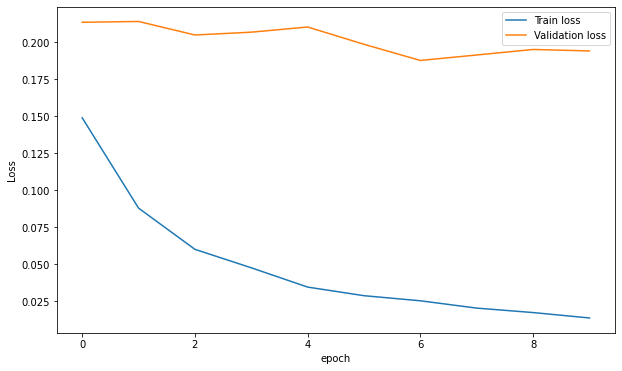

In [ ]:
from tensorflow import keras

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    history = model.fit([frame_rgb, frame_audio, video_rgb, video_audio], labels, validation_split = 0.2, epochs=200, batch_size=64, shuffle=False, callbacks=[early_stop])    
    return history
history_bilstm = fit_model(model)

  # Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_bilstm)

In [ ]:
 def ap_at_n(predictions, actuals, n=20, total_num_positives=None):
    """Calculate the non-interpolated average precision.
    Args:
      predictions: a numpy 1-D array storing the sparse prediction scores.
      actuals: a numpy 1-D array storing the ground truth labels. Any value
        larger than 0 will be treated as positives, otherwise as negatives.
      n: the top n items to be considered in ap@n.
      total_num_positives : (optionally) you can specify the number of total
        positive in the list. If specified, it will be used in calculation.
    Returns:
      The non-interpolated average precision at n.
      If n is larger than the length of the ranked list,
      the average precision will be returned.
    Raises:
      ValueError: An error occurred when
      1) the format of the input is not the numpy 1-D array;
      2) the shape of predictions and actuals does not match;
      3) the input n is not a positive integer.
    """
    if len(predictions) != len(actuals):
      raise ValueError("the shape of predictions and actuals does not match.")

    if n is not None:
      if not isinstance(n, int) or n <= 0:
        raise ValueError("n must be 'None' or a positive integer."
                         " It was '%s'." % n)

    ap = 0.0

    predictions = numpy.array(predictions)
    actuals = numpy.array(actuals)

    # add a shuffler to avoid overestimating the ap
    predictions, actuals = AveragePrecisionCalculator._shuffle(
        predictions, actuals)
    sortidx = sorted(range(len(predictions)),
                     key=lambda k: predictions[k],
                     reverse=True)

    if total_num_positives is None:
      numpos = numpy.size(numpy.where(actuals > 0))
    else:
      numpos = total_num_positives

    if numpos == 0:
      return 0

    if n is not None:
      numpos = min(numpos, n)
    delta_recall = 1.0 / numpos
    poscount = 0.0

    # calculate the ap
    r = len(sortidx)
    if n is not None:
      r = min(r, n)
    for i in range(r):
      if actuals[sortidx[i]] > 0:
        poscount += 1
        ap += poscount / (i + 1) * delta_recall
    return ap
  

In [ ]:
from sklearn import metrics
print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(labels, pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")


References:

Exploration + Bi-LSTM Model, Amansrivastava